# Define canon for SMK paintings

In [186]:
#import requests
from PIL import Image
import os
import pandas as pd
import numpy as np
import datasets
from tqdm import tqdm
from datasets import Image as Image_ds # change name because of similar PIL module
from datasets import Dataset
from datasets import load_dataset
import urllib.parse
import json
import pickle
import requests
import matplotlib.pyplot as plt 
from sklearn.neighbors import NearestNeighbors
import re
import sys
sys.path.append(os.path.abspath(".."))
from src.utils import plot_neighbors

## Load smk data

We load the SMK data + metadata in a couple of different formats:

df = Pandas DataFrame with SMK metadata on paintings (i.e., smk type "Maleri", "Akvarel", "Miniature" and "Gouache"). It's mainly "Maleri" in this category, though.

metadata = JSON file with *all* metadata from the SMK API, not structured (but indices match pickle file)

ds = HuggingFace dataset with same columns as pandas DF, but also a column storing a PIL image of the painting (mainly used here as it's easy to check the painting when it's stored in a ds)

In [187]:
# read df from csv 
data_path = os.path.join('..', 'data')
df = pd.read_pickle(os.path.join(data_path, 'all_paintings_subset.pkl'))

In [188]:
# load metadata json
json_path = os.path.join(data_path, 'all_paintings_metadata')

# Open and read the JSON file
with open(json_path, 'r') as file:
    metadata = json.load(file)

In [189]:
# load image data
ds = load_dataset("louisebrix/smk_all_paintings", split="train") # all the data is in the 'train' split

In [190]:
# add column with greyscale information from ds (i.e., whether the image is greyscale or not)
df['rgb'] = ds['rgb']

#### Add embeddings

In [191]:
# load embeddings
embeddings = np.load(os.path.join(data_path, 'eva02_clip_all_paintings.npy'))
embeddings.shape

(2085, 1024)

In [192]:
# load greyscaled embeddings
grey_embeddings = np.load(os.path.join(data_path, 'GREY_eva02_clip_all_paintings.npy'))
grey_embeddings.shape

(2085, 1024)

In [193]:
# need to convert to list of arrays to add to df
embeddings_list = list(embeddings)
grey_embeddings_list = list(grey_embeddings)
df['embedding'] = embeddings_list
df['grey_embedding'] = grey_embeddings_list

In [194]:
# make sure embeddings are still np arrays and has the correct shape
print(type(df['embedding'].iloc[0]))
print(df['embedding'].iloc[0].shape)
print(type(df['grey_embedding'].iloc[0]))
print(df['grey_embedding'].iloc[0].shape)

<class 'numpy.ndarray'>
(1024,)
<class 'numpy.ndarray'>
(1024,)


In [195]:
df = df.query('main_type == "Maleri"')
indices = df.index.tolist()
df.reset_index(drop=True, inplace=True)
ds = ds.select(indices)

In [196]:
# select metadata based on indices
metadata = [metadata[i] for i in indices]

Besides the metadata we already have in our df, we need to extract some extra data from the metadata json we can use for defining a canon of paintings and add it to our df:

In [197]:
def extract_canon_info(item):

    ''''
    Get information on canon features from smk item
    '''

    content_keys = ['exhibitions',
                    'acquisition_date', 
                    'responsible_department', 
                    'documentation', 
                    'on_display', 
                    'current_location_name',
                    'literary_reference',
                    'object_history_note']

    content_data = {field: item.get(field, pd.NA) for field in content_keys}

    return content_data

In [198]:
data_dicts = []
for item in tqdm(metadata, total=len(metadata)):
    content_data = extract_canon_info(item)
    data_dicts.append(content_data)

data_df = pd.DataFrame(data_dicts)
df = pd.concat([df, data_df], axis=1)     

100%|██████████| 1690/1690 [00:00<00:00, 306378.53it/s]


In [199]:
df.head(5)

,smk_id,period,start_year,title,first_artist,all_artists,num_artists,main_type,all_types,image_thumbnail,...,embedding,grey_embedding,exhibitions,acquisition_date,responsible_department,documentation,on_display,current_location_name,literary_reference,object_history_note
0,KMS8884,1835,1835,Parti af torvet i Amalfi,Martinus Rørbye,[Martinus Rørbye],1,Maleri,[Maleri],https://iip-thumb.smk.dk/iiif/jp2/tt44ps41w_km...,...,"[0.2547459602355957, -0.6865944862365723, 0.94...","[-0.4250355362892151, -1.0564152002334595, 0.7...","[{'exhibition': '""Danish Golden Age"" Petit Pal...",2018-11-27T00:00:00Z,Den Kongelige Maleri- og Skulptursamling,<NA>,True,Sal 219,<NA>,<NA>
1,KMS4313,1870,1870,Leonora Christina i fængslet,Kristian Zahrtmann,[Kristian Zahrtmann],1,Maleri,[Maleri],https://iip-thumb.smk.dk/iiif/jp2/7d278w98c_KM...,...,"[0.7342177629470825, -0.6139540076255798, 0.10...","[0.5037139654159546, -0.522186279296875, -0.02...","[{'exhibition': 'Ære være Leonora', 'date_star...",1941-01-01T00:00:00Z,Den Kongelige Maleri- og Skulptursamling,[{'title': 'Dansk kunst: tusind års kunsthisto...,False,<NA>,<NA>,<NA>
2,KMS3880,1800,1800,Jurisprudensen. Allegorisk figur,Nicolai Abildgaard,[Nicolai Abildgaard],1,Maleri,[Maleri],https://iip-thumb.smk.dk/iiif/jp2/mw22v869s_KM...,...,"[0.722366213798523, -0.381448358297348, -0.525...","[0.2561178207397461, -0.24371886253356934, -0....",[{'exhibition': 'Nicolai Abildgaard - Kroppen ...,1930-01-01T00:00:00Z,Den Kongelige Maleri- og Skulptursamling,[{'title': 'Fortegnelse over den danske Samlin...,False,<NA>,<NA>,[På auktion efter Abildgaards enke solgt til J...
3,KMS7591,1800,1800,Filosofien,Nicolai Abildgaard,[Nicolai Abildgaard],1,Maleri,[Maleri],https://iip-thumb.smk.dk/iiif/jp2/3x816q91r_KM...,...,"[0.24958491325378418, -0.5673973560333252, -0....","[-0.01927855610847473, -0.5728319883346558, -0...",[{'exhibition': 'Nicolai Abildgaard - Kroppen ...,1991-01-01T00:00:00Z,Den Kongelige Maleri- og Skulptursamling,[{'title': 'Abildgaard=abildgård: kunstneren m...,False,<NA>,<NA>,<NA>
4,KMS3769,1844,1844,Udsigt fra Athenatemplet på Akropolis,Martinus Rørbye,[Martinus Rørbye],1,Maleri,[Maleri],https://iip-thumb.smk.dk/iiif/jp2/w0892f396_KM...,...,"[-0.5517070889472961, 0.07065780460834503, 0.8...","[-1.139587163925171, -0.4562285244464874, 0.76...",<NA>,1926-01-01T00:00:00Z,Den Kongelige Maleri- og Skulptursamling,[{'title': 'Lysets malere: nordisk malerkunst ...,True,Sal 219,<NA>,<NA>


In [200]:
# get exhibition venues to check how many are from smk
def exhb_venues(exhb_dict):
    if exhb_dict is not pd.NA:
        venues = []
        for i in range(len(exhb_dict)):
            venue = exhb_dict[i].get('venue', pd.NA)
            venues.append(venue)
        return venues
    
    else:
        return pd.NA

In [201]:
venues_list = [exhb_venues(exhb_dict) for exhb_dict in df['exhibitions']]
df['exhibition_venues'] = venues_list

If a painting has been in an exhibition at SMK it will be under 'Sølvgade' (the adress for SMK) in 'venues'

In [202]:
def check_smk(venues):
    if isinstance(venues, list):
        if any(isinstance(v, str) and 'Sølvgade' in v for v in venues):
            return True 
        else:
            return False 
    else:
        return False

In [203]:
smk_exhibitions = [check_smk(venues) for venues in df['exhibition_venues']]
df['smk_exhibitions'] = smk_exhibitions

In [204]:
def extract_enrichment_wiki_info(smk_id, session):

    '''
    Make calls to enrichment API and relevant extract information
    '''
    try:
        try:
            # enrichment API can't handle slashes in the smk_id as it sees them as part of the path, so they need to be encoded properly
            encoded_smk_id = urllib.parse.quote(smk_id, safe='')
            enrichment_url = f'https://enrichment.api.smk.dk/api/enrichment/{encoded_smk_id}'
            enrichment_request = session.get(enrichment_url)
            enrichment_json = enrichment_request.json()
        
        except Exception:
            # SMK API is case insensitive but Enrichment API is not, so try to make the smk_id uppercase in case this is why the request fails
            uppercase_smk_id = smk_id.upper()
            encoded_smk_id = urllib.parse.quote(uppercase_smk_id, safe='')
            enrichment_url = f'https://enrichment.api.smk.dk/api/enrichment/{encoded_smk_id}'
            enrichment_request = session.get(enrichment_url)
            enrichment_json = enrichment_request.json()

        wiki_data = pd.NA
        for item in enrichment_json:
            if item.get('type') == 'wikidata':
                
                wiki_data = item.get('data', pd.NA).get('wikidata_link_da_s', pd.NA)
                
                break

    # if request still fails, print error message and append NA for this object
    except Exception as e:
        #print(f"Error fetching enrichment API data: {enrichment_url}")
        return pd.NA

    return wiki_data

In [170]:
# not sure we need this (and code takes some time to run)
#wiki_data_list = [extract_enrichment_wiki_info(smk_id, session) for smk_id in df['smk_id']]
#df['wiki_data'] = wiki_data_list
#df[~df['wiki_data'].isna()]

Add column with information about whether an exhibition was called something specific with 'gold'

In [205]:
golden = ['gold', 'guld']

def exhb_venues(exhb_dict):
    if exhb_dict is not pd.NA:
        titles = []
        for i in range(len(exhb_dict)):
            title = exhb_dict[i].get('exhibition', None)

            if title:
                # Check if any keyword matches (case-insensitive)
                if any(re.search(keyword, title.lower()) for keyword in golden):
                    titles.append(title)

        return titles if titles else pd.NA
    else:
        return pd.NA 

In [206]:
golden_titles = [exhb_venues(exhb_dict) for exhb_dict in df['exhibitions']]
df['golden_titles'] = golden_titles
len(df['golden_titles'].value_counts())

79

In [207]:
# convert columns to 0/1 instead of True/False
df['smk_exhibitions'] = df['smk_exhibitions']*1
df['on_display'] = df['on_display']*1

Create variable on whether the artwork has been exhibited anywhere:

In [208]:
def check_exhibitions(exhibitions):
    if isinstance(exhibitions, list):
        return 1 
    else:
        return 0 

In [209]:
exhibitions = [check_exhibitions(exb) for exb in df['exhibitions']]
df['exb_canon'] = exhibitions

### Check correlations

In [210]:
n_exhibitions_list = []
n_golden_titles_list = []

for idx, row in df.iterrows():    
    n_exhibitions_list.append(len(row['exhibition_venues']) if isinstance(row['exhibition_venues'], list) else pd.NA)
    n_golden_titles_list.append(len(row['golden_titles']) if isinstance(row['golden_titles'], list) else pd.NA)

In [211]:
df['n_exhibitions'] = n_exhibitions_list
df['n_golden_titles'] = n_golden_titles_list 

In [212]:
def n_smk_venues(venues):

    n_venues = 0

    if isinstance(venues, list):
        for v in venues:
            if isinstance(v, str) and v == 'Sølvgade':
                n_venues += 1
            else: 
                n_venues += 0
    else:
        n_venues += 0

    return n_venues

In [213]:
n_smk_exhibitions = [n_smk_venues(venues) for venues in df['exhibition_venues']]
df['n_smk_exhibitions'] = n_smk_exhibitions

In [214]:
no_na_df = df.fillna(0)

/var/folders/m8/6qm1yrz575b68s5y27_5z0jc33spwq/T/ipykernel_3159/2020816724.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  no_na_df = df.fillna(0)


In [215]:
def plot_correlation(target_column, columns):
    fig, ax = plt.subplots(1, 1, figsize = (10,4))
    columns.remove(target_column)

    for i, v in enumerate(columns):
        ax.scatter(no_na_df[target_column], no_na_df[v])
        ax.set_title(f'Correlation coef: {round(no_na_df[target_column].corr(no_na_df[v]), 3)}')
        ax.set_xlabel(target_column)
        ax.set_ylabel(v)

    fig.show()

/var/folders/m8/6qm1yrz575b68s5y27_5z0jc33spwq/T/ipykernel_3159/1478878060.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


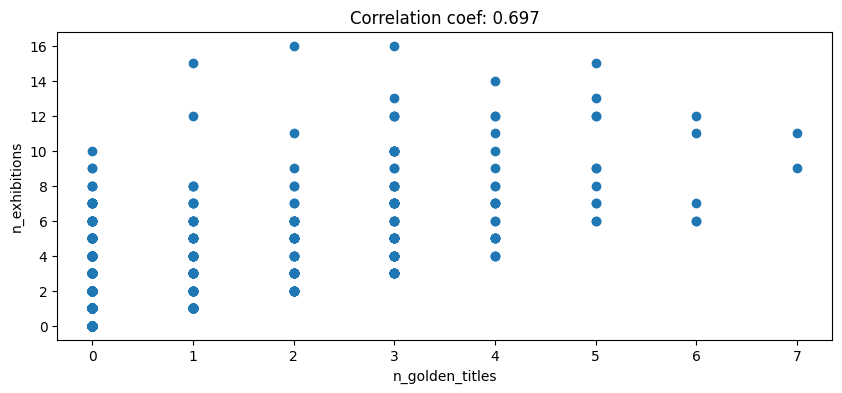

In [216]:
columns = ['n_exhibitions',
 'n_golden_titles']
plot_correlation('n_golden_titles', columns)

In [217]:
# check corr variables

df_corr = df[['n_exhibitions', 'n_golden_titles', 'n_smk_exhibitions', 'on_display']].fillna(0)

corr = df_corr.corr()
corr.style.background_gradient(cmap='coolwarm')

/var/folders/m8/6qm1yrz575b68s5y27_5z0jc33spwq/T/ipykernel_3159/625316017.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_corr = df[['n_exhibitions', 'n_golden_titles', 'n_smk_exhibitions', 'on_display']].fillna(0)


,n_exhibitions,n_golden_titles,n_smk_exhibitions,on_display
n_exhibitions,1.000000,0.696654,0.773202,0.489196
n_golden_titles,0.696654,1.000000,0.643270,0.365066
n_smk_exhibitions,0.773202,0.643270,1.000000,0.521833
on_display,0.489196,0.365066,0.521833,1.000000


In [218]:
# check corr variables

df_corr_nona = df[['n_exhibitions', 'n_golden_titles', 'n_smk_exhibitions', 'on_display']].dropna(how='any')

corr = df_corr_nona.corr()
corr.style.background_gradient(cmap='coolwarm')

,n_exhibitions,n_golden_titles,n_smk_exhibitions,on_display
n_exhibitions,1.000000,0.605747,0.689682,0.508893
n_golden_titles,0.605747,1.000000,0.451292,0.389436
n_smk_exhibitions,0.689682,0.451292,1.000000,0.508364
on_display,0.508893,0.389436,0.508364,1.000000


In [219]:
df = df.query('main_type == "Maleri"')
indices = df.index.tolist()
df.reset_index(drop=True, inplace=True)
ds = ds.select(indices)

### Add column on exhibition years

In [220]:
def get_ex_years(ex_dict_list):
    
    dates = []
    if isinstance(ex_dict_list, list):
        
        for e in ex_dict_list:
            start_date = e.get('date_start', None)

            if start_date:
                start_year = start_date.split('-')[0]
                dates.append(start_year)
            else:
                dates.append(pd.NA)
        
    else:
        dates = pd.NA
    
    return dates

In [221]:
ex_dates = [get_ex_years(ex_dict_list) for ex_dict_list in df['exhibitions']]
df['ex_years'] = ex_dates

#### Add column on exhibition 'distances'

In [222]:
def get_ex_distances(row):

    prod_year = row['start_year']
    diffs = []

    if isinstance(row['ex_years'], list):
        for year in row['ex_years']:
            if isinstance(year, str):
                diff = int(year) - int(prod_year) 
                diffs.append(diff)
            else:
                diffs.append(pd.NA)
    else:
        diffs = pd.NA
    
    return diffs

In [223]:
ex_distances = [get_ex_distances(row) for idx, row in df.iterrows()]
df['ex_distances'] = ex_distances

In [224]:
def get_ex_distances_smk(row):

    if pd.notna(row['acquisition_date']):
        acq_year = row['acquisition_date'].split('-')[0]
        diffs = []

        if isinstance(row['ex_years'], list):
            for idx, year in enumerate(row['ex_years']):
                if isinstance(year, str) and isinstance(row['exhibition_venues'], list):
                    if pd.notna(row['exhibition_venues'][idx]) and row['exhibition_venues'][idx] == 'Sølvgade':
                        diff = int(year) - int(acq_year) 
                        diffs.append(diff)
                    else:
                        diffs.append(pd.NA)
                else:
                    diffs.append(pd.NA)
        else:
            diffs = pd.NA
    else:
        diffs = pd.NA
    return diffs

In [225]:
smk_distances = [get_ex_distances_smk(row) for idx, row in df.iterrows()]
df['smk_distances'] = smk_distances

In [226]:
dist_canon = []
for dists in df['ex_distances']:

    canon = 0
    if isinstance(dists, list):
        big_dists = [i for i in dists if i > 150]

        if len(big_dists) > 0:
            canon =+ 1
        else:
            canon =+ 0
        dist_canon.append(canon)
    else:
        dist_canon.append(0)

In [227]:
df['dist_canon'] = dist_canon

#### Add exhibitions canon

In [228]:
exb_canon = []

for idx, row in df.iterrows():
    exb_years = row['ex_years']

    if isinstance(exb_years, list):
        match = False
        for year in exb_years:
            if year.startswith('2') == True:
                match = True
                break
            
            else:
                continue

        if match == True:
            exb_canon.append('canon')
        
        else:
            exb_canon.append('other')

    else:
        exb_canon.append('other')

df['exb_canon'] = exb_canon

#### Make canon index by copying the formula by M. Tolonen et al. (2021)

In [229]:
no_na_df = df.fillna(0)
total_exb_count = no_na_df['n_exhibitions'].sum()

/var/folders/m8/6qm1yrz575b68s5y27_5z0jc33spwq/T/ipykernel_3159/2339353792.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  no_na_df = df.fillna(0)


In [233]:
unique_years = [np.unique(years).tolist() for years in no_na_df['ex_years']]
no_na_df['unique_exb_years'] = unique_years

In [234]:
# calculate canon index based on formula by M. Tolonen et al.
def canon_idx(row, total_exb_count):

    unique_exb_years = len(row['unique_exb_years'])

    idx = unique_exb_years * (row['n_exhibitions'] / total_exb_count)

    return idx

In [235]:
canon_idxes = [canon_idx(row, total_exb_count) for idx, row in no_na_df.iterrows()]
df['canon_idx'] = canon_idxes

In [237]:
def add_mean_prod_year(df):

    mean_years = []

    for idx, row in df.iterrows():
        if '-' in row['period']:
        #row['period'].str.contains('-'):
            start_year = int(row['period'].split('-')[0])
            end_year = int(row['period'].split('-')[-1])
        
            mean_year = (start_year + end_year) // 2
            mean_years.append(mean_year)

        else:
            mean_years.append(row['start_year'])


    df['mean_prod_year'] = mean_years

    return df

In [238]:
df = add_mean_prod_year(df)

In [239]:
# change canon variables from 0 / 1 to other / canon
columns = ['exb_canon', 'dist_canon', 'on_display', 'smk_exhibitions']

for column in columns:
    df[column] = df[column].replace({0: 'other', 1: 'canon'})

In [240]:
df['smk_exhibitions'].value_counts()

smk_exhibitions
other    1320
canon     370
Name: count, dtype: int64

In [241]:
# write new df with canon info to disk
df.to_pickle(os.path.join(data_path, 'paintings_canonized.pkl'))

In [242]:
# save metadata dicts
with open(os.path.join(data_path, 'metadata_paintings'), "w") as json_file:
    json.dump(metadata, json_file, indent=2)